In [9]:
!python -m venv tfenv
!.\tfenv\Scripts\activate  # Windows

In [1]:
import cv2
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset

C:\Users\cagin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
DB = "database/images/brain-tumor-mri-dataset"
LABELS_DICT = {"glioma":0, 
               "meningioma":1,
              "notumor":2,
              "pituitary": 3}
INV_LABELS_DICT = {v: k for k, v in LABELS_DICT.items()}
os.listdir(DB)

['glioma', 'meningioma', 'notumor', 'pituitary']

In [3]:
os.listdir(DB)

['glioma', 'meningioma', 'notumor', 'pituitary']

In [4]:
def process_image(args):
    img_path, label = args
    image = cv2.imread(img_path)
    if image is None:
        return None
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (64, 64))
    image = image/255.0
    return image, LABELS_DICT[label]

In [5]:
def get_data_with_threads(path):
    start = time.time()
    tasks = []
    X = []
    y = []
    
    for label in os.listdir(path):
        new_path = path + "/" + label
        for img in os.listdir(new_path):
            img_path = new_path + "/" + img
            tasks.append((img_path, label))
    
    with ThreadPoolExecutor() as executor:
        for result in executor.map(process_image, tasks):
            if result is not None:
                img, lbl = result
                X.append(img)
                y.append(lbl)
    
    end = time.time()
    return np.array(X), np.array(y), end-start
    

In [6]:
def class_distribution(labels):
    plt.figure(figsize=(8, 8))
    class_counts = pd.Series(labels).value_counts().sort_index()
    
    class_names = [INV_LABELS_DICT[label] for label in class_counts.index]
    plt.pie(class_counts, labels=class_names,
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 13})
    plt.title('Class Distribution', fontdict={"fontsize": 17})
    plt.show()

In [7]:
X, y, time_with_thread = get_data_with_threads(DB)

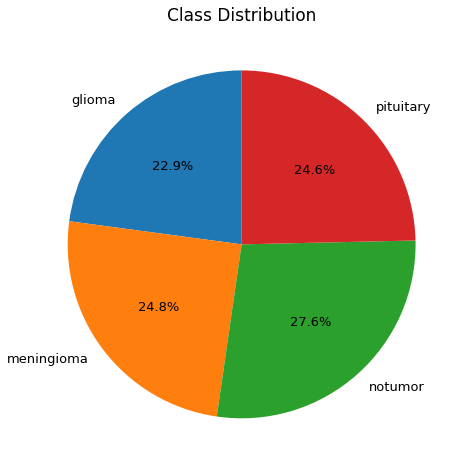

In [8]:
class_distribution(y)

In [9]:
len(X), len(y)

(7060, 7060)

In [10]:
def plot_some_examples(X, y):
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), 5, figsize=(15, 3 * len(classes)))

    for i, class_name in enumerate(classes):
        class_images = X[y == class_name][:5]
        for j in range(5):
            axes[i, j].imshow(class_images[j], cmap='gray')
            axes[i, j].set_title(f'{INV_LABELS_DICT[class_name]}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

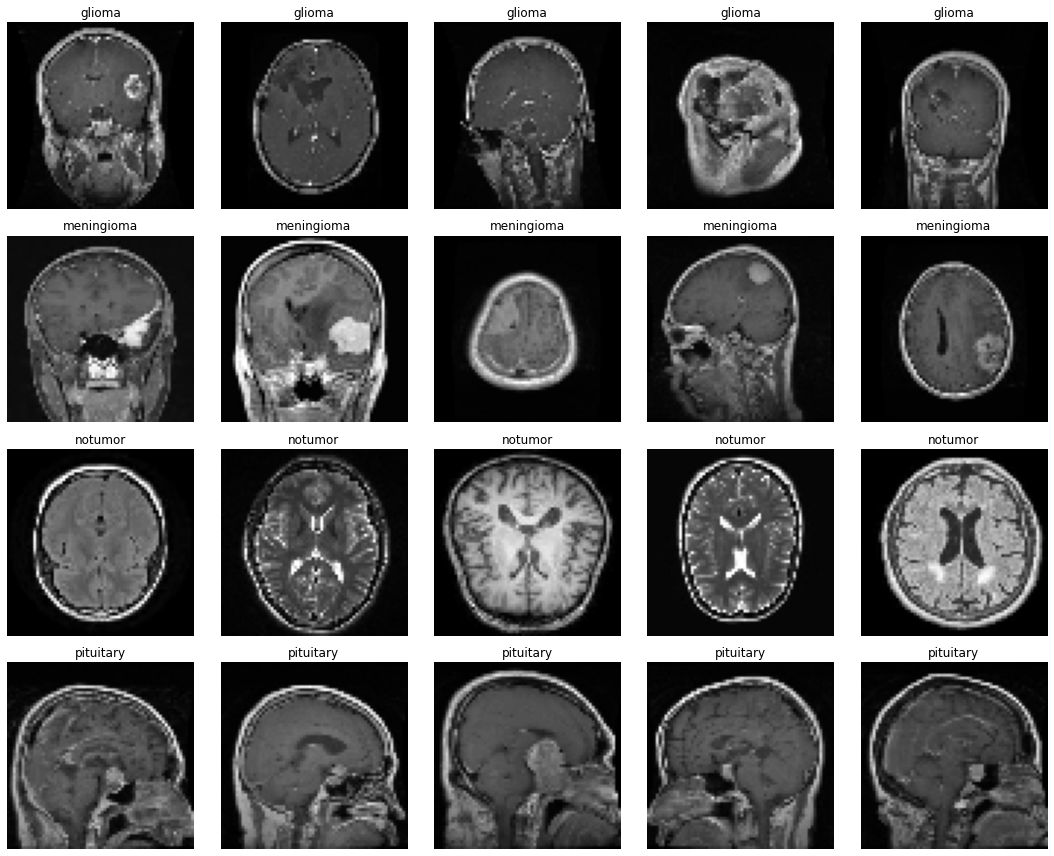

In [11]:
plot_some_examples(X,y)

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2) 
        self.conv_layer_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.linear_1 = nn.Linear(64*16*16, 128)
        self.linear_2 = nn.Linear(128, 4)
        self.dropout_1 = nn.Dropout(0.25)
        self.dropout_2 = nn.Dropout(0.1)
        
    def forward(self, x):
        x = self.conv_layer_1(x) #(B, 32, 64, 64)
        x = F.relu(x) 
        x = self.pool(x) #(B, 32, 32, 32)
        x = self.dropout_1(x)
        
        x = self.conv_layer_2(x) #(B, 64, 32, 32)
        x = F.relu(x)
        x = self.pool(x) #(B, 64, 16, 16)
        x = self.dropout_2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.linear_1(x) #(B, 64*16*16, 128)
        x = F.relu(x)
        
        x = self.linear_2(x) #(B, 128, 3)
        x = F.softmax(x)
        return x


In [13]:
def train_test(X, y, k_folds=3, epochs=3):
    folds = []
    predictions = []
    
    dataset = TensorDataset(X, y)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    class_counts = torch.bincount(y)
    weights = 1.0 / class_counts.float()
    weights = weights / weights.sum()  # normalize to sum to 1
    print(f"Using class weights: {weights.tolist()}")

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f'\nFold {fold + 1}')

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64)

        model = CNN()
        criterion = nn.CrossEntropyLoss(weight=weights)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        fold_results = []
        for epoch in range(epochs):
            model.train()
            running_loss = 0
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            print(f"Epoch {epoch+1} - Training Loss: {running_loss:.4f}")

            # Validation
            model.eval()
            correct, total = 0, 0
            all_preds = []
            with torch.no_grad():
                for images, labels in val_loader:
                    outputs = model(images)
                    preds = torch.argmax(outputs, dim=1)
                    all_preds.append(preds)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
            acc = 100 * correct / total
            fold_results.append(acc)
            print(f"Epoch {epoch+1} - Validation Accuracy: {acc:.2f}%")
        folds.append(f"Fold {fold}")
        predictions.append(fold_results)
        all_preds = torch.cat(all_preds)
        unique_classes, counts = torch.unique(all_preds, return_counts=True)
        print(f"Predicted class distribution: {dict(zip(unique_classes.tolist(), counts.tolist()))}")
    return folds, predictions

In [14]:
def train(X, y, epochs=5):
    # Weights
    class_distribution = torch.bincount(y)
    preweights = 1.0/class_distribution
    weights = preweights / preweights.sum().item()
    
    # Declarations
    model = CNN()
    criterion = nn.CrossEntropyLoss(weight=weights)
    opti = optim.Adam(model.parameters(), lr=0.001)
    X = X.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    losses = {}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for idx in range(0, len(X_train)-64, 64):
            x = X_train[idx:idx+64]
            opti.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y_train[idx:idx+64])
            loss.backward()
            opti.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1} - Training Loss: {running_loss:.4f}")
        losses[f"Epoch {epoch}"] = running_loss
        
        model.eval()
        test_score = 0
        total = 0
        with torch.no_grad():
            for idx in range(0, len(y_test)-64, 64):
                x_t = X_test[idx:idx+64]
                y_t = y_test[idx:idx+64]
                output = model(x_t)
                pred = torch.argmax(output, dim=1)
                test_score += (pred == y_t).sum().item()
                total += y_t.size(0)
        print(f"Test score is: {test_score/total}")
    return model, losses

In [15]:
X = torch.tensor(X, dtype=torch.float32)
if X.ndim == 3:
    X = X.unsqueeze(1)  # (N, 64, 64) → (N, 1, 64, 64)
    
y = torch.tensor(y, dtype=torch.long)

In [16]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: torch.Size([7060, 1, 64, 64])
y shape: torch.Size([7060])


In [17]:
print(torch.bincount(y))

tensor([1615, 1754, 1951, 1740])


In [18]:
model, losses = train(X, y, epochs=65)

C:\Users\cagin\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<ipython-input-12-a873e7fa37af>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch 1 - Training Loss: 97.3035
Test score is: 0.7350852272727273
Epoch 2 - Training Loss: 86.8988
Test score is: 0.7776988636363636
Epoch 3 - Training Loss: 82.6202
Test score is: 0.8174715909090909
Epoch 4 - Training Loss: 81.3527
Test score is: 0.8231534090909091
Epoch 5 - Training Loss: 79.0420
Test score is: 0.8323863636363636
Epoch 6 - Training Loss: 77.5512
Test score is: 0.8565340909090909
Epoch 7 - Training Loss: 76.7416
Test score is: 0.8693181818181818
Epoch 8 - Training Loss: 75.9314
Test score is: 0.8792613636363636
Epoch 9 - Training Loss: 75.5904
Test score is: 0.8806818181818182
Epoch 10 - Training Loss: 75.4344
Test score is: 0.8622159090909091
Epoch 11 - Training Loss: 74.3940
Test score is: 0.8686079545454546
Epoch 12 - Training Loss: 73.7364
Test score is: 0.8842329545454546
Epoch 13 - Training Loss: 73.4721
Test score is: 0.8849431818181818
Epoch 14 - Training Loss: 72.6848
Test score is: 0.8934659090909091
Epoch 15 - Training Loss: 72.5089
Test score is: 0.864346

In [19]:
scripted_model = torch.jit.script(model)  # Convert model to TorchScript
torch.jit.save(scripted_model, "brain_1.pth")

In [ ]:
array = losses.keys()
for i in array:
    print(i)
    new_i = int(i.split()[1])
    
    losses[new_i] = losses[i]
    del losses[i]

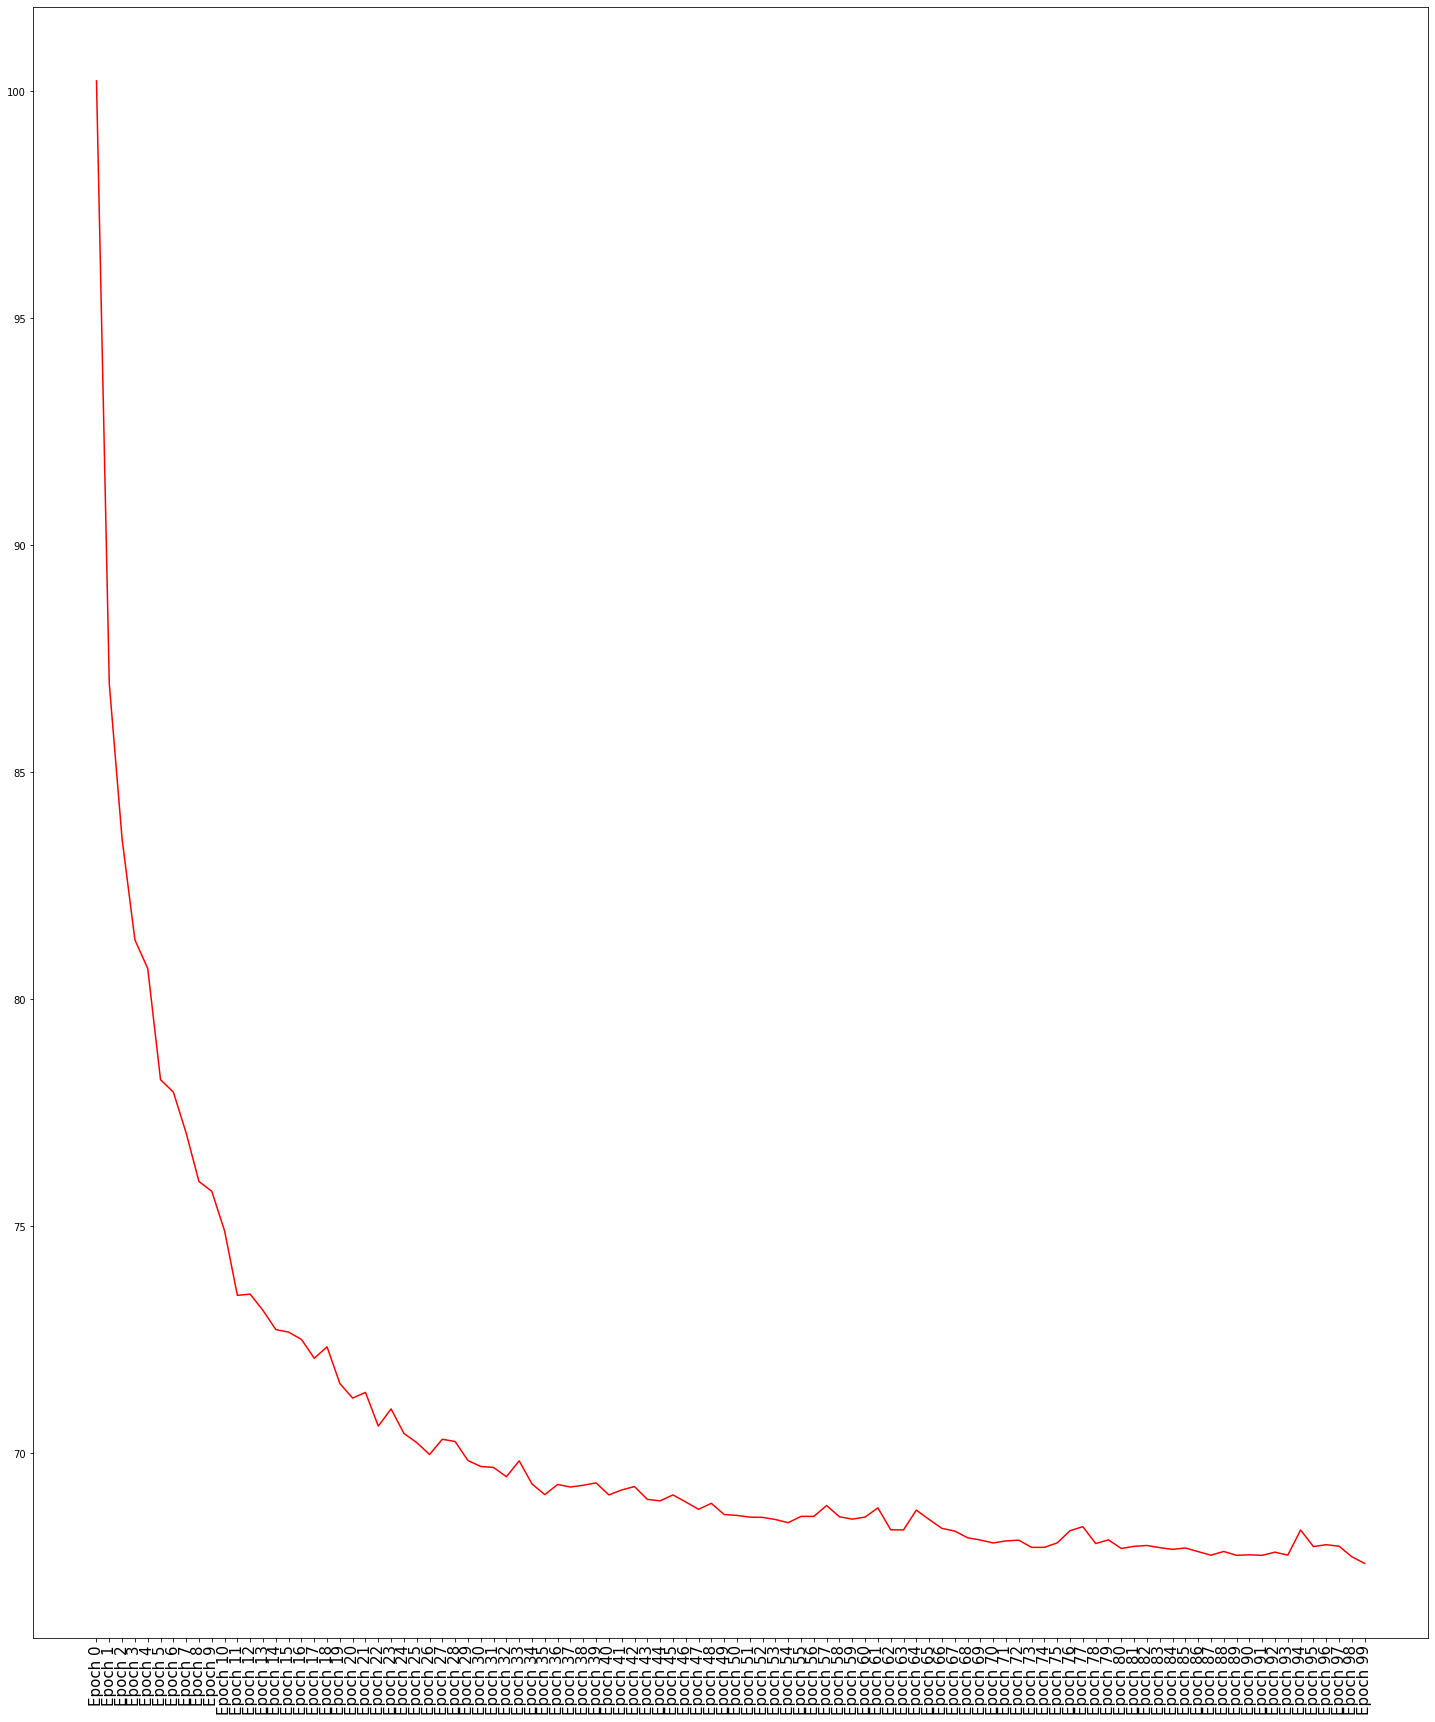

In [49]:
plt.figure(figsize=(25, 30))
plt.plot(losses.keys(), losses.values(), color="red")
plt.xticks(rotation=90, fontsize=15)
plt.show()

In [ ]:
folds, preds = train_test(X, y, k_folds=5, epochs=5)

In [ ]:
folds_epochs = []
predictions = []
mean_prediction = []
for i in range(len(folds)):
    fold = folds[i]
    current = preds[i]
    tmp = []
    for j in range(len(current)):
        predictions.append(current[j])
        tmp.append(current[j])
        folds_epochs.append(f"{fold}\nEpoch: {j}")
    [mean_prediction.append(np.mean(np.array(tmp))) for j in range(len(current))]

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(folds_epochs, predictions, color="darkred", label="Accuracy for each fold and mean")
plt.plot(folds_epochs, mean_prediction, color="darkblue", label="Mean of the epoch")
plt.xticks(rotation=60)
plt.title("Training Test Results")
plt.xlabel("Epoch and Fold")
plt.ylabel("Accuracy")
plt.legend()

plt.show()